#### Time Series Analysis and Forecasting

In [1]:
from helper_funcs import *
import numpy as np
import pandas as pd
from scipy.stats import boxcox
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set(style="darkgrid")

In [2]:
df = pd.read_csv('data/data.csv', index_col=['dt'], parse_dates=['dt'])

In [3]:
df.head(7)

,MW
dt,
2011-01-01 00:00:00,3416.0
2011-01-01 00:15:00,4755.0
2011-01-01 00:30:00,4939.0
2011-01-01 00:45:00,4939.0
2011-01-01 01:00:00,4998.0
2011-01-01 01:15:00,5184.0
2011-01-01 01:30:00,5341.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 385566 entries, 2011-01-01 00:00:00 to 2021-12-30 07:45:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   MW      385566 non-null  float64
dtypes: float64(1)
memory usage: 5.9 MB


In [5]:
# Resampling based on months
df_monthly = pd.DataFrame(df.MW.resample('M').mean())
df_monthly.head(3)

,MW
dt,
2011-01-31,1597.289987
2011-02-28,1674.951637
2011-03-31,1665.180013


In [6]:
df_monthly.isnull().any()

MW    False
dtype: bool

In [7]:
df_monthly.describe()

,MW
count,132.000000
mean,3184.899640
std,1219.654190
min,1320.366263
25%,2204.808017
50%,2955.428582
75%,4029.462758
max,7323.836616


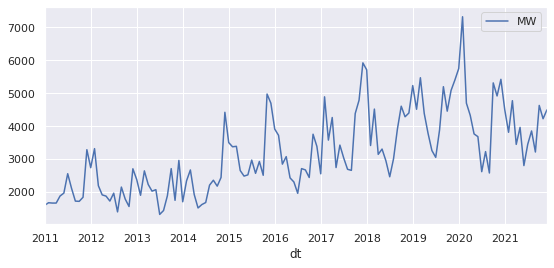

In [8]:
df_monthly.plot(figsize=(9, 4));

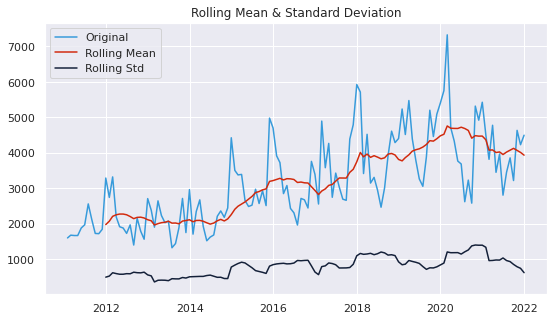

In [9]:
# Rolling Statistics:
# window size denotes 12 months, giving rolling mean and std at a yearly level
rolling_stats(df_monthly.MW, 12)

From the two plots above:
- There's an upward trend, and the variation seems to increase over time.
- The rolling std is more constant at the beginning, and fluctuates and increases towards the end.
- Some seasonal effect is traced: peaks are observed in the last month of the year and troughs - in the middle of the year.

The time series is not stationary.<br>
Verifying with the Dickey-Fuller test `(H0=non-stationary and H1=stationary, p-value 0.05)`:

Results of Dickey-Fuller Test:
Test Statistic                  -1.286391
p-value                          0.635375
#Lags Used                      10.000000
Number of Observations Used    121.000000
Critical Value (1%)             -3.485585
Critical Value (5%)             -2.885739
Critical Value (10%)            -2.579676
dtype: float64


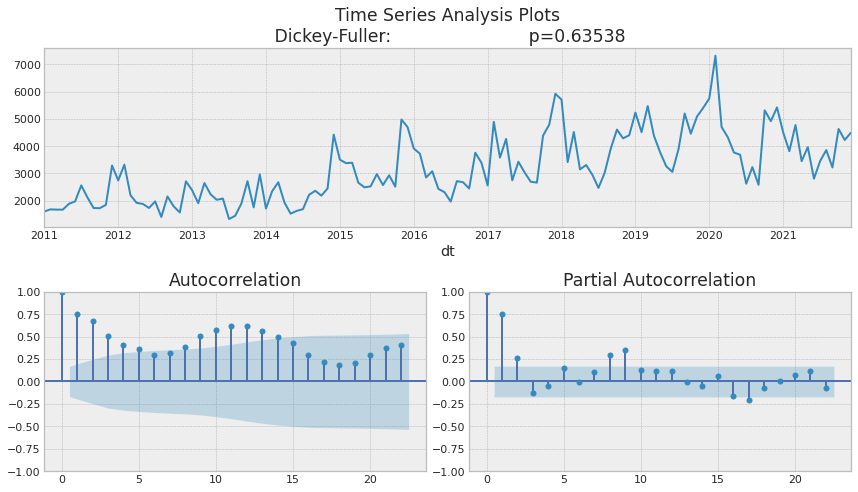

In [10]:
tsplot(df_monthly.MW)

The value of the test statistic -1.286391 > critical value at all confidence intervals and the p-value 0.635375 > 0.05.<br>
The null hypothesis cannot be rejected. The series is non-stationary.

**Decomposition**

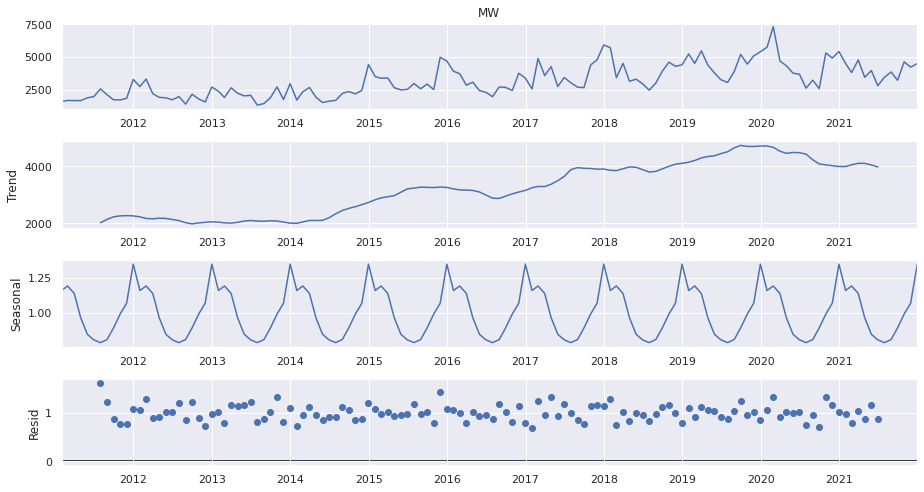

In [11]:
# multiplicative model
decomposition_m = seasonal_decompose(df_monthly.MW, model='multiplicative',
                                     period=12)  # a year

plt.rcParams["figure.figsize"] = [13, 7]
plot_acc = decomposition_m.plot()

From the decomposition:

- The plot shows an upward trend.
- Residual: values widely distributed around 1, and there're outliers.

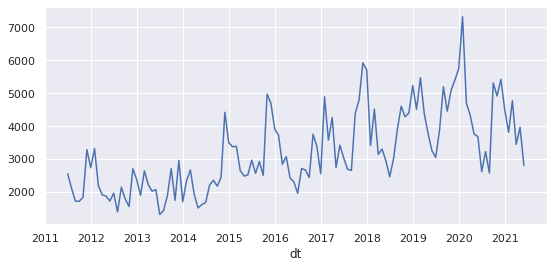

In [12]:
# Reconstruct the series
plt.rcParams["figure.figsize"] = [9, 4]
reconstructed_m = (decomposition_m.trend * decomposition_m.seasonal *
                    decomposition_m.resid).plot()

To make the series stationary, applying differentiation:

Results of Dickey-Fuller Test:
Test Statistic                -8.166776e+00
p-value                        8.839816e-13
#Lags Used                     8.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


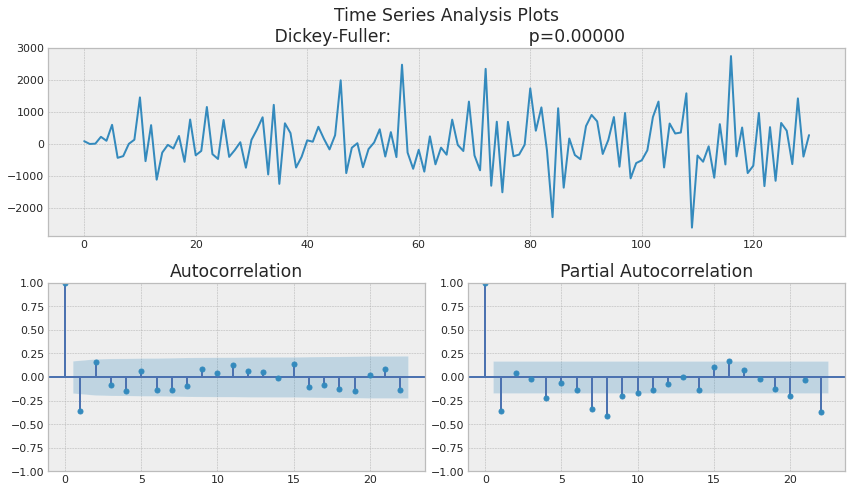

In [13]:
series_m = np.diff(df_monthly.MW, 1)
tsplot(series_m)

As the value of the test statistic < critical value at all confidence intervals and the p-value < 0.05, the null hypothesis can be rejected.<br>
The time series is now stationary. The series values fluctuate around zero. The significant peaks are no longer on the autocorrelation func plot.

----------------
Due to the presence of seasonality, the model selected for forecasting - SARIMA.

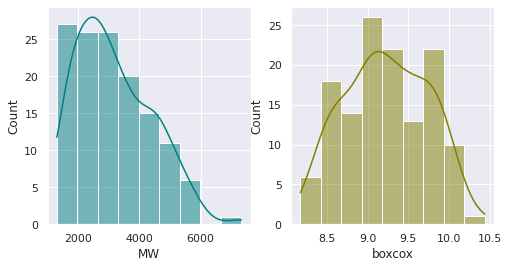

In [14]:
# Boxcox transformation
data, lambda_power = boxcox(df_monthly['MW'])
df_monthly['boxcox'] = data

fig, axs = plt.subplots(1,2, figsize=(8, 4))
sns.histplot(df_monthly.MW, kde=True, color="teal", ax=axs[0])
sns.histplot(df_monthly.boxcox, kde=True, color="olive", ax=axs[1])
plt.show()

In [15]:
obtain_adf_kpss_results(df_monthly.boxcox, 3)

,d,adf_stats,p-value (kpss),is_adf_stationary,is_kpss_stationary,is_stationary
0,0,7.715461e-01,0.01,False,False,False
1,1,1.307388e-09,0.10,True,True,True
2,2,1.155756e-12,0.10,True,True,True


Applying differentiation once makes the time series stationary: `d=1`

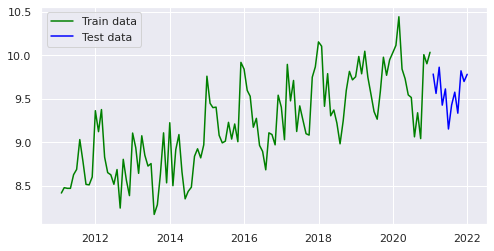

In [16]:
df_monthly.index.freq = 'M'
Ntest = 12

train = df_monthly.iloc[:-Ntest]
test = df_monthly.iloc[-Ntest:]

plt.figure(figsize=(8, 4))
plt.plot(train['boxcox'], 'green', label='Train data')
plt.plot(test['boxcox'], 'blue', label='Test data')
plt.legend()
plt.show()

Estimating coefficients for SARIMA:

In [17]:
# seasonal model
model = pm.auto_arima(train['boxcox'], seasonal=True, m=12, d=1,
                      start_p=0, start_q=0, start_P=0, start_Q=0,
                 	  max_p=6, max_q=6, max_P=6, max_Q=6, max_D=2,
                      information_criterion='aic',
                      trace=True, error_action='ignore',
                      stepwise=True,
                      suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=87.731, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=69.553, Time=0.22 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=69.044, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=85.916, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=74.609, Time=0.03 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=56.998, Time=0.51 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=67.592, Time=0.09 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=58.607, Time=0.79 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=58.280, Time=0.86 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=70.833, Time=0.78 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=66.876, Time=0.26 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=60.808, Time=0.90 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=87.551, Time=0.14 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(0,1,2)(1,0,1)[12] intercept   : AIC=inf, Ti

In [18]:
# MAE (residuals)
mae = np.mean(np.abs(model.resid()))
print('MAE: %.3f' % mae)
print(model.summary())

MAE: 0.292
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 -20.425
Date:                            Mon, 24 Oct 2022   AIC                             52.850
Time:                                    22:23:01   BIC                             69.525
Sample:                                01-31-2011   HQIC                            59.621
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2832      0.117      2.411      0.016       0.053       0.513
ar.L2          0.1649   

Prob(Q) (Ljung–Box test) = 0.95 > 0.05.  The H0 that the residuals are uncorrelated cannot be rejected, so the `residuals are not correlated`.

Prob(JB) (Jarque–Bera test) = 0.31 > 0.05. The H0 that the residuals are normally distributed cannot be rejected. The residuals are `normally distributed`.

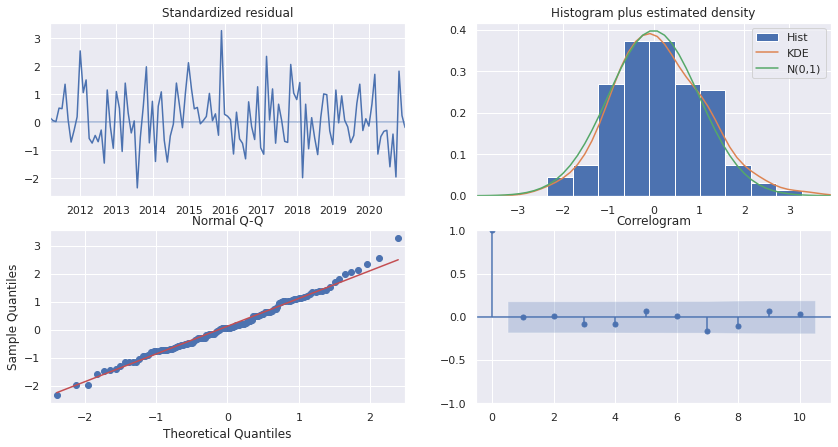

In [19]:
model.plot_diagnostics(figsize=(14, 7))
plt.show()

Analyzing the plots:

* *Standardized residual*: The residual errors fluctuate around a mean of zero.

* *Histogram plus kde estimate*: The orange curve is similar to the green one of a normal distribution (for a good model the orange line should be similar to the green line).

* *Correlogram* or ACF plot: The residual errors are not autocorrelated, almost all of them are not significant (inside the blue area).

* *Normal Q-Q:* Most of the data points lie on the straight line, indicating a normal distribution of the residuals. However, there're some outliers at the upper right, not covered by the line.

In [20]:
train_preds = model.predict_in_sample(start=1, end=-1)  # d=1
test_preds, conf_interval = model.predict(n_periods=Ntest,
                                          return_conf_int=True)

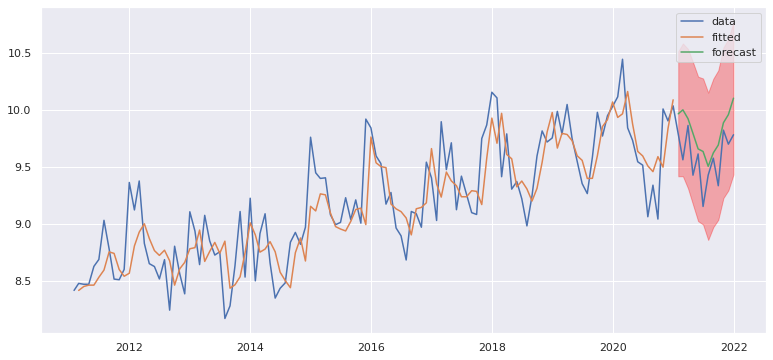

In [21]:
fig, ax = plt.subplots(figsize=(13, 6))

ax.plot(df_monthly.index, df_monthly['boxcox'], label='data')
ax.plot(train.index[1:], train_preds, label='fitted')
ax.plot(test.index, test_preds, label='forecast')
ax.fill_between(test.index, conf_interval[:, 0],
                conf_interval[:, 1], color='red', alpha=0.3)
ax.legend()
plt.show()

In [22]:
rmse = mean_squared_error(test['boxcox'].values, test_preds, squared=False)
mape = mean_absolute_percentage_error(test['boxcox'].values, test_preds.values)

print('RMSE: {}'.format(np.round(rmse, 2)))
print('MAPE: {}%'.format(np.round(mape, 2)))

RMSE: 0.27
MAPE: 2.36%


The model gives a quite good forecast showing both ups and downs with the MAPE value of 2.36%.